In [12]:
from math import floor, ceil

from scipy.linalg import expm, eigh, norm, det
from scipy.optimize import minimize
from scipy.stats import gaussian_kde, unitary_group

import numpy as np
from numpy import outer, trace, kron, trace, shape, real, sqrt, exp, cos, sin, pi
from numpy.linalg import eig, eigh, norm, svd

import seaborn as sns

from functools import reduce
from itertools import product, combinations

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile
from qiskit.circuit import Parameter

import time
import copy
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc, gridspec


def hea_ansatz_eff(qubits_number, layers_number, target_qubits=None):

    hardware_efficient_ansatz = []
    
    if target_qubits is None:
        target_qubits = [i for i in range(qubits_number)]
    
    target_qubits_number = len(target_qubits)
    
    block_number = 0
    for k in range(layers_number):

        for i in range(target_qubits_number):
            
            hardware_efficient_ansatz.append({'layer_number': k,
                                              'block_number': block_number,
                                              'operator': 'su2',
                                              'qubits': [target_qubits[i]],
                                              'parameters': [random.uniform(-4*np.pi, 4*np.pi) for w in range(3)],
                                              'daggered': False,
                                              'derivatives': []})
            block_number += 3
            
            

        for i in range(target_qubits_number - 1):
            hardware_efficient_ansatz.append({'layer_number': k,
                                              'block_number': block_number,
                                              'operator': 'cr_y',
                                              'qubits': [target_qubits[i], target_qubits[i+1]],
                                              'parameters': [random.uniform(-4*np.pi, 4*np.pi)],
                                              'daggered': False,
                                              'derivatives': []})
            block_number += 1

        if target_qubits_number > 2:
            hardware_efficient_ansatz.append({'layer_number': k,
                                              'block_number': block_number,
                                              'operator': 'cr_y',
                                              'qubits': [target_qubits[-1], target_qubits[0]],
                                              'parameters': [random.uniform(-4*np.pi, 4*np.pi)],
                                              'daggered': False,
                                              'derivatives': []})
            block_number += 1

    return hardware_efficient_ansatz


def extract_parameters_from_tensor_network(tensor_network):
    
    parameters = []
    
    for block in tensor_network:
        parameters = parameters + list(block['parameters'])
    
    return parameters


def update_tensor_network(tensor_network, new_parameters):

    # replaces the parameters of given tensor network by the new ones
    
    if len(new_parameters) != tensor_network_parameters_number(tensor_network):
        raise ('error')
    
    parameters_updated = 0
    for block in tensor_network:
        parameters_number = len(block['parameters'])
        block['parameters'] = new_parameters[parameters_updated : parameters_updated+parameters_number]
        parameters_updated += parameters_number

    return None


def tensor_network_parameters_number(tensor_network):
    
    # returns total number of parameters in given tensor network
    
    parameters_number = 0

    for block in tensor_network:
        parameters_number += len(block['parameters'])

    return parameters_number


def tensor_network_to_qiskit_circuit(qubits_number, tensor_network, quantum_register=None, classical_register=None):
    
    # translates given tensor network into a Qiskit circuit object
    
    if quantum_register is None:
        quantum_register = QuantumRegister(qubits_number)
    if classical_register is None:
        classical_register = ClassicalRegister(qubits_number)
    
    circuit = QuantumCircuit(quantum_register, classical_register)
       
    for block in tensor_network:
        
        if block['operator'] == 'r_x':
            circuit.rx(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
        elif block['operator'] == 'r_y':
            circuit.ry(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
        elif block['operator'] == 'r_z':
            circuit.rz(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
        elif block['operator'] == 'cx':
            circuit.cx(block['qubits'][0], block['qubits'][1])
        elif block['operator'] == 'cz':
            circuit.cz(block['qubits'][0], block['qubits'][1])            
        elif block['operator'] == 'cr_y':
            circuit.cu3(2*block['parameters'][0] + pi*block['derivatives'].count(0), 0, 0, block['qubits'][0], block['qubits'][1])
        elif block['operator'] == 'su2':
#             circuit.rx(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
#             circuit.ry(2*block['parameters'][1] + pi*block['derivatives'].count(1), block['qubits'][0])
#             circuit.rx(2*block['parameters'][2] + pi*block['derivatives'].count(2), block['qubits'][0])
            circuit.u3(2*block['parameters'][0] + pi*block['derivatives'].count(0), 2*block['parameters'][1] + pi*block['derivatives'].count(1), 2*block['parameters'][2] + pi*block['derivatives'].count(2), block['qubits'][0])
        elif block['operator'] == 'ising':
            circuit.rx(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
            circuit.rx(2*block['parameters'][1] + pi*block['derivatives'].count(1), block['qubits'][1])
            circuit.rzz(2*block['parameters'][2] + pi*block['derivatives'].count(2), block['qubits'][0], block['qubits'][1])
            circuit.rz(2*block['parameters'][3] + pi*block['derivatives'].count(3), block['qubits'][0])
            circuit.rz(2*block['parameters'][4] + pi*block['derivatives'].count(4), block['qubits'][1])
        elif block['operator'] == 'rank1':
            circuit.rx(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
            circuit.ry(2*block['parameters'][1] + pi*block['derivatives'].count(1), block['qubits'][0])
            circuit.rx(2*block['parameters'][2] + pi*block['derivatives'].count(2), block['qubits'][0])
            circuit.rx(2*block['parameters'][3] + pi*block['derivatives'].count(3), block['qubits'][1])
            circuit.ry(2*block['parameters'][4] + pi*block['derivatives'].count(4), block['qubits'][1])
            circuit.rx(2*block['parameters'][5] + pi*block['derivatives'].count(5), block['qubits'][1])
        elif block['operator'] == 'rank2':
            circuit.ry(2*block['parameters'][0] + pi*block['derivatives'].count(0), block['qubits'][0])
            circuit.cx(block['qubits'][0], block['qubits'][1])
            circuit.rx(2*block['parameters'][1] + pi*block['derivatives'].count(1), block['qubits'][0])
            circuit.ry(2*block['parameters'][2] + pi*block['derivatives'].count(2), block['qubits'][0])
            circuit.rx(2*block['parameters'][3] + pi*block['derivatives'].count(3), block['qubits'][0])
            circuit.rx(2*block['parameters'][4] + pi*block['derivatives'].count(4), block['qubits'][1])
            circuit.ry(2*block['parameters'][5] + pi*block['derivatives'].count(5), block['qubits'][1])
            circuit.rx(2*block['parameters'][6] + pi*block['derivatives'].count(6), block['qubits'][1])

    return circuit


def renyi_entropy(density_matrix, a=2):
    
    d = len(density_matrix)
    c = 1 / (1 - a)

    for j in range(a):
        density_matrix = density_matrix.dot(density_matrix)
    
    return c * np.log(trace( density_matrix)).real #/ np.log(d)

def von_neumann_entropy(density_matrix):
    
    evals, evecs = eigh(density_matrix)
    
    entropy = 0
    for e in evals:
        if e > 0:
            ee = e #+ 1e-10
            entropy += ee * np.log(ee)
    return -entropy / np.log(2)
    

def approximate_mps_qiskit(n_qubits, initial_statevector, state_tensor_network, unitary, method, options={}):
    
    backend = Aer.get_backend('statevector_simulator')
    
    fun_values = []
    overlaps = []
    entropies = []
    
    d = len(unitary)
    n = 2 ** int(n_qubits/2)
    m = int(d / n)
    exact_eigenvectors = eig(unitary)[1]
    
    qreg = QuantumRegister(n_qubits)
    creg = ClassicalRegister(n_qubits)
    
    initial_parameters = extract_parameters_from_tensor_network(state_tensor_network)
    n_parameters = len(initial_parameters)
    parameters_symbs = [Parameter('p' + str(i)) for i in range(n_parameters)]
    parameter_binds = [{parameters_symbs[i]: initial_parameters[i] for i in range(n_parameters)}]
    
    update_tensor_network(state_tensor_network, parameters_symbs)
    
    circuit = QuantumCircuit(qreg, creg)
    circuit.initialize(initial_statevector, [i for i in range(n_qubits)])
    ansatz = tensor_network_to_qiskit_circuit(n_qubits, state_tensor_network, qreg, creg)
    ansatz = transpile(ansatz, backend=backend, optimization_level=3)
    circuit = circuit + ansatz

    # first iteration #
    
    job = execute(circuit, backend=backend, parameter_binds=parameter_binds)   
    statevector = job.result().get_statevector()
    
    overlap = 0
    for i in range(d):
        overlap_i = abs(statevector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            overlap = overlap_i
    overlaps.append(overlap)
    
    fun_value = 1 - abs(statevector.conj().T.dot(unitary).dot(statevector))**2
    fun_values.append(fun_value)

    state_dm = np.outer(statevector, statevector.conj().T)
    state_dm_reduced = trace(state_dm.reshape((n, m, n, m)), axis1=0, axis2=2)
    entropies.append(von_neumann_entropy(state_dm_reduced))
    
    # work #
    
    statevector_reserve = [None]
    fun_value_reserve = [None]
    def fun(x):      
        
        parameter_binds = [{parameters_symbs[i]: x[i] for i in range(n_parameters)}]
        
        job = execute(circuit, backend=backend, parameter_binds=parameter_binds)   
        statevector = job.result().get_statevector()

        fun_value = 1 - abs(statevector.conj().T.dot(unitary).dot(statevector))**2
        
        statevector_reserve.pop()
        fun_value_reserve.pop()
        statevector_reserve.append(statevector)
        fun_value_reserve.append(fun_value)
        
        return fun_value

    def callback(xk):        
        
        statevector = statevector_reserve[0]
        overlap = 0
        for i in range(d):
            overlap_i = abs(statevector.conj().T.dot(exact_eigenvectors[:,i]))**2
            if  overlap_i > overlap:
                overlap = overlap_i
        overlaps.append(overlap)

        fun_value = fun_value_reserve[0]
        fun_values.append(fun_value)
        
        state_dm = np.outer(statevector, statevector.conj().T)
        state_dm_reduced = trace(state_dm.reshape((n, m, n, m)), axis1=0, axis2=2)
        entropies.append(von_neumann_entropy(state_dm_reduced))
        
        return None
        
    optimization_result = minimize(fun=fun, x0=initial_parameters, callback=callback, method=method, options=options)
    
    
    # last iteration # 
    
    parameter_binds = [{parameters_symbs[i]: optimization_result.x[i] for i in range(n_parameters)}]
    
    job = execute(circuit, backend=backend, parameter_binds=parameter_binds)   
    statevector = job.result().get_statevector()
    
    overlap = 0
    for i in range(d):
        overlap_i = abs(statevector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            overlap = overlap_i
    overlaps.append(overlap)
    
    fun_value = 1 - abs(statevector.conj().T.dot(unitary).dot(statevector))**2
    fun_values.append(fun_value)

    state_dm = np.outer(statevector, statevector.conj().T)
    state_dm_reduced = trace(state_dm.reshape((n, m, n, m)), axis1=0, axis2=2)
    entropies.append(von_neumann_entropy(state_dm_reduced))
    
    return fun_values, overlaps, entropies, optimization_result, statevector


def input_reader(file_name):
    
    """Reads inputs from a file"""
    
    input_dict = {}
    
    file = open(file_name, "r")
    for line in file:
        line_split = line.split(':')
        input_dict[line_split[0]] = line_split[1].replace(" ", "")
    file.close()
    
    input_dict['n_qubits'] = int(input_dict['n_qubits'])
    input_dict['n_instances'] = int(input_dict['n_instances'])
    input_dict['method'] = input_dict['method'].replace("\n", "")
    
    return input_dict

Iteration 1
	 rank: 1
		 Completed in 5.0251805782318115
	 rank: 2
		 Completed in 70.74313116073608
Iteration 2
	 rank: 1
		 Completed in 4.343012809753418
	 rank: 2
		 Completed in 68.21375036239624
Completed in 148.3260624408722


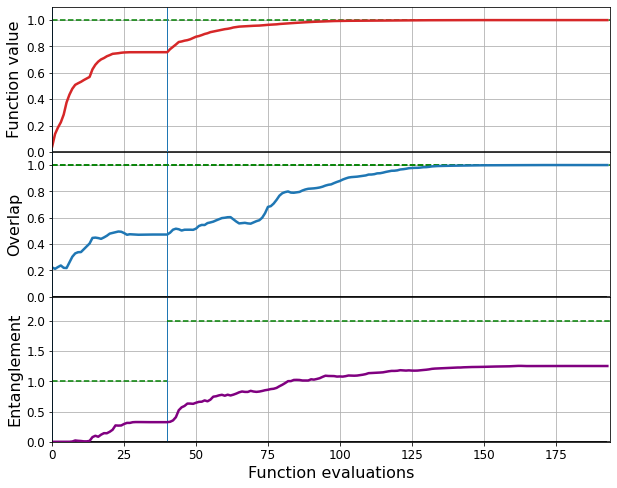

In [17]:
def main():
    
    input_dict = input_reader('input.txt')
    n_qubits = input_dict['n_qubits']
    max_rank = ceil(n_qubits/2)
    n_instances = input_dict['n_instances']
    method = input_dict['method']

    unitaries = [unitary_group.rvs(2**n_qubits) for i in range(n_instances)]

    fun_values = [[0]]*max_rank
    overlaps = [[0]]*max_rank
    entropies = [[0]]*max_rank

    start_time = time.time()

    for p in range(n_instances):
        print('Iteration', p + 1)
        initial_state_vec = np.array([1] + [0]*(2**n_qubits - 1))

        for rank in range(1, max_rank + 1):

            print('\t rank:', rank)
            local_time = time.time()
            state_tensor_network = []
            for n in range(n_qubits - rank):
                target_qubits = [(i + n) for i in range(rank + 1)]
                state_tensor_network = state_tensor_network + hea_ansatz_eff(n_qubits, rank, target_qubits)
            for i in range(len(state_tensor_network)):
                state_tensor_network[i]['block_number'] = i
            n_pars = len(extract_parameters_from_tensor_network(state_tensor_network))
            update_tensor_network(state_tensor_network, [0 for i in range(n_pars)])

            result = approximate_mps_qiskit(n_qubits, initial_state_vec, state_tensor_network, unitaries[p], method)

            l = len(result[0])
            k = rank - 1

            fun_values[k] = np.concatenate((fun_values[k], [fun_values[k][-1]]*(l - len(fun_values[k]))))
            new_fun_values = np.concatenate((result[0], [result[0][-1]]*(len(fun_values[k]) - l)))
            fun_values[k] = np.array(fun_values[k]) + np.array(new_fun_values)

            overlaps[k] = np.concatenate((overlaps[k], [overlaps[k][-1]]*(l - len(overlaps[k]))))
            new_overlaps = np.concatenate((result[1], [result[1][-1]]*(len(overlaps[k]) - l)))
            overlaps[k] = np.array(overlaps[k]) + np.array(new_overlaps)

            entropies[k] = np.concatenate((entropies[k], [entropies[k][-1]]*(l - len(entropies[k]))))
            new_entropies = np.concatenate((result[2], [result[2][-1]]*(len(entropies[k]) - l)))
            entropies[k] = np.array(entropies[k]) + np.array(new_entropies)

            initial_state_vec = result[4]
            print('\t\t Completed in', time.time() - local_time)

    verts = [0]
    for line in fun_values:
        verts.append(verts[-1] + len(line))
    # verts.pop(-1)

    fun_values_flat = np.array([])
    for line in fun_values:
        fun_values_flat = np.concatenate((fun_values_flat, line))
    fun_values_flat = fun_values_flat / n_instances   

    overlaps_flat = np.array([])
    for line in overlaps:
        overlaps_flat = np.concatenate((overlaps_flat, line))
    overlaps_flat = overlaps_flat / n_instances

    entropies_flat = np.array([])
    for line in entropies:
        entropies_flat = np.concatenate((entropies_flat, line))
    entropies_flat = entropies_flat / n_instances

    print('Completed in', time.time() - start_time)
    
    
    # write the data
    file = open('fun_values_flat.txt', 'w')
    for fun_value in fun_values_flat:
        file.write(str(fun_value) + '\n')
    file.close()
    file = open('overlaps_flat.txt', 'w')
    for overlap in overlaps_flat:
        file.write(str(overlap) + '\n')
    file.close()
    file = open('entropies_flat.txt', 'w')
    for entropy in entropies_flat:
        file.write(str(entropy) + '\n')
    file.close()
    
    
    # plot
    figsize = (10, 8)
    tickssize = 12
    fontsize = 16
    linewidth = 1

    x_axis = list(range(len(fun_values_flat)))
    x_ticks = x_axis
    s = 0
    k = len(fun_values_flat)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 


    ax0 = plt.subplot(gs[0])#
    ax0.plot(x_axis[s:k], 1 - fun_values_flat[s:k], color='tab:red', linewidth=2.5)
    ax0.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
    ax0.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
    for v in verts:
        ax0.vlines(x=v, ymin=0, ymax=1.1, linestyles='solid', linewidth=1)
    ax0.set_ylabel('Function value', fontsize=fontsize)
    ax0.set_xlim(s, k)
    ax0.set_ylim(0, 1.1)
    ax0.grid()
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=tickssize)

    ax1 = plt.subplot(gs[1])
    plt.plot(x_axis[s:k], overlaps_flat[s:k], color='tab:blue', linewidth=2.5)
    ax1.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
    ax1.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
    for v in verts:
        ax1.vlines(x=v, ymin=0, ymax=1.1, linestyles='solid', linewidth=1)
    ax1.set_ylabel('Overlap', fontsize=fontsize)
    ax1.hlines(y=0, xmin=x_axis[s:][0], xmax=x_axis[s:][-1], colors='black', linestyles='solid')
    ax1.hlines(y=1, xmin=x_axis[s:][0], xmax=x_axis[s:][-1], colors='green', linestyles='dashed')
    ax1.set_xlim(s, k)
    ax1.set_ylim(0, 1.1)
    ax1.grid()
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=tickssize)

    ax2 = plt.subplot(gs[2], sharex = ax1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax2.plot(x_axis[s:k], entropies_flat[s:k], color='purple', linewidth=2.5)
    ax2.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
    for v in verts:
        ax2.vlines(x=v, ymin=0, ymax=max_rank + 0.4, linestyles='solid', linewidth=1)
    ax2.set_xlabel('Function evaluations', fontsize=fontsize)
    ax2.set_ylabel('Entanglement', fontsize=fontsize)
    ax2.hlines(y=0, xmin=x_axis[s:][0], xmax=x_axis[s:][-1], colors='black', linestyles='solid')
    for r in range(1, max_rank + 1):
        ax2.hlines(y=r, xmin=verts[r-1], xmax=verts[r], colors='green', linestyles='dashed')
    ax2.set_xlim(s, k)
    ax2.set_ylim(0, max_rank + 0.4)
    ax2.grid()
    plt.xticks(fontsize=tickssize)
    plt.yticks(fontsize=tickssize)

    plt.subplots_adjust(hspace=0)

    plt.savefig(str(n_qubits) + 'q-' + str(max_rank) + 'l-' + str(n_instances) + 'i-' + method + '.pdf', bbox_inches='tight')
#     plt.show()
    
    
if __name__ == '__main__':
    main()